In [39]:
import pandas as pd
import numpy as np  
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
import pylab as plt
import xarray as xr
import random

In [40]:
X_val = np.load('X_valid_sst_new.npy')
Y_val = np.load('Y_valid_sst_new.npy')
X_train = np.load('X_train_sst_new.npy')
Y_train = np.load('Y_train_sst_new.npy')

In [41]:
X_train = X_train.transpose((0, 3, 1, 2))
X_train = np.expand_dims(X_train, axis = 4)
X_train.shape

(2700, 12, 10, 43, 1)

In [42]:
X_val = X_val.transpose((0, 3, 1, 2))
X_val = np.expand_dims(X_val, axis = 4)
X_val.shape

(300, 12, 10, 43, 1)

In [43]:

def create_convlstm_model(input_shape):
    x = keras.layers.Input(shape = input_shape)
    
    y = keras.layers.ConvLSTM2D(12, (3,3), activation='relu', padding = 'same',return_sequences=True)(x)
    y = keras.layers.MaxPooling3D(pool_size=(1, 4, 4))(y)

    y = keras.layers.ConvLSTM2D(24, (3,3), activation='relu', padding = 'same',return_sequences=True)(y)
    y = keras.layers.MaxPooling3D(pool_size=(1, 4, 4))(y)

    y = keras.layers.ConvLSTM2D(24, (3,3), activation='relu', padding = 'same',return_sequences=False)(y)
    
    y = keras.layers.GlobalAveragePooling2D()(y)

#    y = keras.layers.Dropout(0.5)
    
    y = keras.layers.Dense(12) (y)    # add final output layer with a softmax activation
    model = keras.models.Model(inputs=x, outputs=y)
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanSquaredError'])
    
    return model

In [44]:

def create_convlstm_model_simple(input_shape):
    x = keras.layers.Input(shape = input_shape)
    
    y = keras.layers.ConvLSTM2D(12, (3,3), activation='relu', padding = 'same',return_sequences=True)(x)
    y = keras.layers.MaxPooling3D(pool_size=(1, 4, 4))(y)
    
    y = keras.layers.ConvLSTM2D(24, (3,3), activation='relu', padding = 'same',return_sequences=True)(y)
    y = keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(y)
    
    y = keras.layers.ConvLSTM2D(24, (3,3), activation='relu', padding = 'same',return_sequences=False)(y)
    
    y = keras.layers.GlobalAveragePooling2D()(y)

#    y = keras.layers.Dropout(0.5)
    
    y = keras.layers.Dense(12) (y)    # add final output layer with a softmax activation
    model = keras.models.Model(inputs=x, outputs=y)
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanSquaredError'])
    
    return model

In [45]:
CONVLSTM = create_convlstm_model_simple(input_shape = (12,10,43,1))
# take a look at how the image tensor changes shape as it passes through the CNN:
CONVLSTM.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 10, 43, 1)]   0         
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 12, 10, 43, 12)    5664      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 12, 2, 10, 12)    0         
 3D)                                                             
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 12, 2, 10, 24)     31200     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 12, 1, 5, 24)     0         
 3D)                                                             
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 1, 5, 24)          4156

In [46]:
n_epochs = 10
hist = CONVLSTM.fit(X_train,Y_train, epochs=n_epochs, validation_data=(X_val,Y_val))

Epoch 1/10
85/85 [==============================] - 146s 2s/step - loss: 1.4500 - mean_squared_error: 1.4500 - val_loss: 1.1970 - val_mean_squared_error: 1.1970
Epoch 2/10
85/85 [==============================] - 114s 1s/step - loss: 1.0675 - mean_squared_error: 1.0675 - val_loss: 0.8876 - val_mean_squared_error: 0.8876
Epoch 3/10
85/85 [==============================] - 112s 1s/step - loss: 0.8115 - mean_squared_error: 0.8115 - val_loss: 0.7114 - val_mean_squared_error: 0.7114
Epoch 4/10
85/85 [==============================] - 112s 1s/step - loss: 0.7328 - mean_squared_error: 0.7328 - val_loss: 0.7235 - val_mean_squared_error: 0.7235
Epoch 5/10
85/85 [==============================] - 113s 1s/step - loss: 0.6984 - mean_squared_error: 0.6984 - val_loss: 0.5955 - val_mean_squared_error: 0.5955
Epoch 6/10
85/85 [==============================] - 104s 1s/step - loss: 0.6577 - mean_squared_error: 0.6577 - val_loss: 0.5779 - val_mean_squared_error: 0.5779
Epoch 7/10
85/85 [================

In [48]:
Y_predictions = CONVLSTM.predict(X_val)
error = np.sqrt(np.mean((Y_val - Y_predictions)**2, axis=0))


10/10 [==============================] - 3s 243ms/step


<xarray.Dataset>
Dimensions:    (lat: 64, lon: 96, time: 1980)
Coordinates:
  * lat        (lat) float64 -89.06 -86.23 -83.4 -80.58 ... 83.4 86.23 89.06
  * lon        (lon) float64 1.25 5.0 8.75 12.5 ... 346.2 350.0 353.8 357.5
  * time       (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
    member_id  object ...
Data variables:
    SST        (time, lat, lon) float32 ...


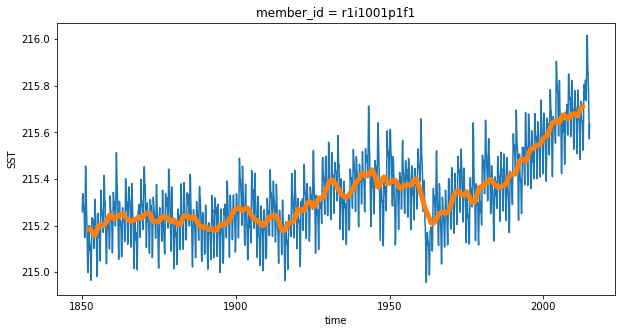

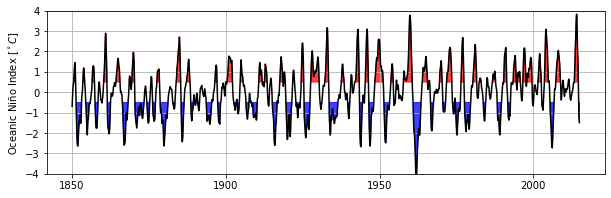

In [49]:
enso1='~/ENSO_SST/ENSO_Project_SST_r1i1001p1f1.nc'
enso1 = xr.open_dataset(enso1)  #xarray can open different format data, netcdf is one of them
print(enso1)                                

sst_1 = enso1['SST'].values; df_sst_1 = enso1.to_dataframe()

weights = np.cos(np.deg2rad(enso1.lat)); weights.name = "weights" # area of the cell scales as dlat*dlon*cos(lat) and we can use it to compute weighted averages; note, dlat=dlon for this dataset.
SST_mean = enso1['SST'].weighted(weights).mean(dim=['lat','lon']) # this IS area-weighted mean
SST_mean_runningMean=SST_mean.rolling(time=12*5,center=True).mean() # global mean smoothed over many months

plt.figure(figsize=(10,5))
SST_mean.plot(label="SST" )
SST_mean_runningMean.plot(label="SST rolling mean", linewidth=5 );

enso1_clim=enso1.groupby("time.month").mean('time') # calculate anomalies
enso1_a = enso1.groupby("time.month")-enso1_clim

NINO34 = enso1_a['SST'].sel(lat=slice(-5,5), lon=slice(190,240)).mean(dim=['lat','lon'])
ONI= NINO34.rolling(time=3,center=True).mean() #rolling mean over 3 months

plt.figure(figsize=(10,3))
ax=plt.gca()
plt.plot(ONI.time, ONI,'k')
ax.fill_between(ONI.time.data, 0.5, ONI, ONI> 0.5, color='red', alpha=.75)
ax.fill_between(ONI.time.data, -0.5, ONI, ONI< -0.5, color='blue',  alpha=.75)
plt.ylim((-4,4))
plt.grid(visible=True)
plt.ylabel('Oceanic Niño Index [$^\circ C$]');

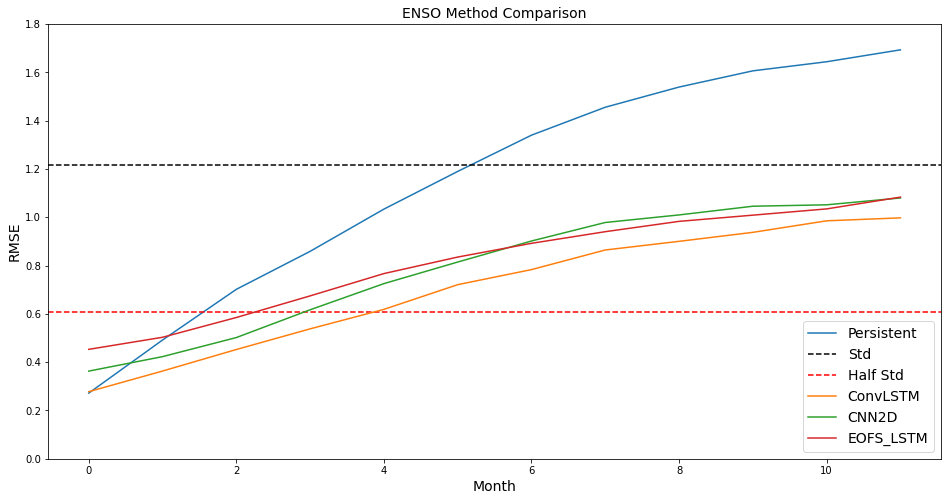

In [106]:
error_persistent = np.zeros((300,12))
for i in range(300):
    i0= random.randint(0,len(NINO34)-13)
    error_persistent[i,:] = (NINO34[i0+1:i0+13] - NINO34[i0].values*np.ones(12))**2
rms_persistence = (np.mean(error_persistent, axis=0))**0.5
plt.figure(figsize=(16,8))
plt.plot(rms_persistence,label='Persistent')
plt.axhline(np.std(NINO34), color='k', linestyle='--',label = 'Std' )
plt.axhline(np.std(NINO34)/2, color='r', linestyle='--', label = 'Half Std')
plt.plot(error, label = 'ConvLSTM')
plt.plot(error_CNN2D, label = 'CNN2D')
plt.plot(error_EOFS_new, label = 'EOFS_LSTM')
plt.xlabel('Month', fontsize = 14)
plt.ylabel('RMSE', fontsize = 14)
plt.legend(loc="lower right", fontsize = 14)
plt.ylim(0,1.8)
plt.title('ENSO Method Comparison', fontsize = 14)
plt.savefig('image.pdf')

In [68]:
error_CNN2D = np.load('errorCNN2D.npy')
error_CNN2D

array([0.36299854, 0.42291963, 0.50185671, 0.61686908, 0.72509581,
       0.81439661, 0.90149043, 0.97812469, 1.00941477, 1.0454178 ,
       1.05129712, 1.0796361 ])

In [81]:
error_EOFS = (0.45306018, 0.50301179, 0.58489728, 0.67432795, 0.76667389, 0.83503021,
 0.89187198, 0.94002651, 0.98277326, 1.00845311, 1.03435177, 1.08307097)
error_EOFS_new = np.asarray(error_EOFS)